# Tests output ForecasterAutoregMultiseries (0.12.0)

In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
sys.path.insert(1, str(Path.cwd().parent))
str(Path.cwd().parent)

# Data management
# ==============================================================================
import numpy as np
import pandas as pd
import joblib

# Graphics
# ==============================================================================
import matplotlib.pyplot as plt
from skforecast.plot import set_dark_theme
set_dark_theme()

# Forecasting
# ==============================================================================
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection  import ParameterGrid
import skforecast
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster
from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.model_selection_multiseries import bayesian_search_forecaster_multiseries
from skforecast.model_selection_multiseries import grid_search_forecaster_multiseries

# Others
# ==============================================================================
import warnings
import sys

print(f"Python version: {sys.version}")
print(f"skforecast version: {skforecast.__version__}")

c:\anaconda\envs\skforecast_11_py12\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Python version: 3.12.0 | packaged by Anaconda, Inc. | (main, Oct  2 2023, 17:20:38) [MSC v.1916 64 bit (AMD64)]
skforecast version: 0.12.0


In [2]:
# Auxiliar functions
# ==============================================================================
def series_long_format_to_dict(
    data: pd.DataFrame,
    series_id: str,
    index: str,
    values: str,
    freq: str,
):
    """
    Convert long format series to dictionary.

    Parameters
    ----------
    data: pd.DataFrame
        Long format series.
    series_id: str
        Column name with the series identifier.
    index: str
        Column name with the time index.
    values: str
        Column name with the values.
    freq: str
        Frequency of the series.

    Returns
    -------
    series_dict: dict
        Dictionary with the series.

    """

    series_dict = {}
    for k, v in data.groupby(series_id):
        series_dict[k] = v.set_index(index)[values].asfreq(freq).rename(k)

    return series_dict


def exog_long_format_to_dict(
    data: pd.DataFrame,
    series_id: str,
    index: str,
    freq: str
):
    """
    Convert long format exogenous variables to dictionary.

    Parameters
    ----------
    data: pd.DataFrame
        Long format exogenous variables.
    series_id: str
        Column name with the series identifier.
    index: str
        Column name with the time index.
    freq: str
        Frequency of the series.
    
    Returns
    -------
    exog_dict: dict
        Dictionary with the exogenous variables.

    """

    exog_dict =  dict(tuple(data.groupby(series_id)))
    exog_dict = {
        k: v.set_index(index).asfreq(freq).drop(columns=series_id)
        for k, v in exog_dict.items()
    }

    return exog_dict

# Test series of same length

In [3]:
# Load time series same length
# ==============================================================================
end_train = '2016-07-31 23:59:00'
end_validation = '2016-09-30 23:59:00'

data  = pd.read_parquet('sample_building_consumption.parquet')
data = data.asfreq('D')
series = data[['id_1000', 'id_1001', 'id_1002', 'id_1003', 'id_1004']]
exog  = data[['sin_day_of_week', 'cos_day_of_week', 'air_temperature', 'wind_speed']]

series_train = series.loc[: end_train, :].copy()
exog_train   = exog.loc[: end_train, :].copy()
series_val   = series.loc[end_train: end_validation, :].copy()
exog_val     = exog.loc[end_train: end_validation, :].copy()
series_test  = series.loc[end_validation:, :].copy()
exog_test    = exog.loc[end_validation:, :].copy()

series_dict = series.to_dict(orient='series')
exog_dict = {k: exog for k in series.columns}
series_dict_train = series_train.to_dict(orient='series')
exog_dict_train = {k: exog_train for k in series.columns}
series_dict_val = series_val.to_dict(orient='series')
exog_dict_val = {k: exog_val for k in series.columns}
series_dict_test = series_test.to_dict(orient='series')
exog_dict_test = {k: exog_test for k in series.columns}

In [4]:
# Version 0.11.0
# ==============================================================================
steps = 10
forecaster = ForecasterAutoregMultiSeries(
    regressor=LinearRegression(), #LGBMRegressor(n_estimators=10, random_state=123, verbose=-1),
    lags=14,
    #encoding="ordinal",
    #dropna_from_series=False,
    transformer_series = StandardScaler()
)

forecaster.fit(series=series_train, exog=exog_train)
predictions_1 = forecaster.predict(steps=steps, exog=exog_val)
predictions_1_interval = forecaster.predict_interval(
    steps=steps, exog=exog_val, interval=[5, 95], n_boot=50
)
predictions_1

,id_1000,id_1001,id_1002,id_1003,id_1004
2016-08-01,1197.511551,2454.433535,4415.213083,3177.532491,7731.904086
2016-08-02,1458.223835,2735.413614,5434.868031,2593.409070,8981.617872
2016-08-03,1449.041351,2785.285886,5592.201365,2236.482266,9205.830352
2016-08-04,1383.524522,2682.872639,5555.356272,2229.642384,9298.586201
2016-08-05,1330.460411,2339.462880,5376.576738,1951.963288,8722.234432
2016-08-06,1130.560544,2008.546442,4527.141910,1996.715225,7221.765952
2016-08-07,974.140434,1693.156788,3554.400035,2675.070480,6584.342801
2016-08-08,1194.313859,1684.225522,4743.608988,2628.782077,7912.128744
2016-08-09,1415.588150,2091.522977,5675.585909,2285.044758,8953.247982
2016-08-10,1418.292039,2278.020136,5712.578502,2193.707535,9174.527363


In [5]:

# Version 0.12.0
# ==============================================================================
steps = 10
forecaster = ForecasterAutoregMultiSeries(
    regressor=LinearRegression(), #LGBMRegressor(n_estimators=10, random_state=123, verbose=-1),
    lags=14,
    encoding="onehot",
    dropna_from_series=False,
    transformer_series = StandardScaler()
)

forecaster.fit(series=series_train, exog=exog_train)
predictions_1 = forecaster.predict(steps=steps, exog=exog_val)
predictions_1_interval = forecaster.predict_interval(
    steps=steps, exog=exog_val, interval=[5, 95], n_boot=50
)
predictions_1

,id_1000,id_1001,id_1002,id_1003,id_1004
2016-08-01,1183.291097,2502.669716,4446.534419,3168.593759,7703.022640
2016-08-02,1434.813046,2811.324961,5482.274209,2579.828978,8934.450226
2016-08-03,1420.160139,2875.858995,5648.018091,2221.427786,9146.017820
2016-08-04,1351.854536,2779.706812,5612.911070,2215.058721,9232.236174
2016-08-05,1295.775133,2442.719249,5439.553243,1937.172339,8648.107250
2016-08-06,1094.171394,2113.922409,4592.960373,1981.848036,7142.792294
2016-08-07,936.506049,1802.743969,3622.188514,2659.352093,6501.089784
2016-08-08,1151.556380,1815.241242,4825.099480,2610.955689,7819.477841
2016-08-09,1369.324480,2239.133986,5763.058915,2265.608523,8853.069493
2016-08-10,1370.577474,2432.044536,5800.630556,2174.760908,9070.893676


In [6]:
# Test predictions
# ==============================================================================
steps = 10
forecaster = ForecasterAutoregMultiSeries(
    regressor=LinearRegression(), #LGBMRegressor(n_estimators=10, random_state=123, verbose=-1),
    lags=14,
    encoding="ordinal",
    dropna_from_series=False,
    transformer_series = StandardScaler()
)

forecaster.fit(series=series_train, exog=exog_train)
predictions_1 = forecaster.predict(steps=steps, exog=exog_val)
predictions_1_interval = forecaster.predict_interval(
    steps=steps, exog=exog_val, interval=[5, 95], n_boot=50
)

forecaster.fit(series=series_train, exog=exog_dict_train)
predictions_2 = forecaster.predict(steps=steps, exog=exog_dict_val)
predictions_2_interval = forecaster.predict_interval(
    steps=steps, exog=exog_dict_val, interval=[5, 95], n_boot=50
)

forecaster.fit(series=series_dict_train, exog=exog_dict_train)
predictions_3 = forecaster.predict(steps=steps, exog=exog_dict_val)
predictions_3_interval = forecaster.predict_interval(
    steps=steps, exog=exog_dict_val, interval=[5, 95], n_boot=50
)

pd.testing.assert_frame_equal(predictions_1, predictions_2)
pd.testing.assert_frame_equal(predictions_1, predictions_3)
pd.testing.assert_frame_equal(predictions_1_interval, predictions_2_interval)
pd.testing.assert_frame_equal(predictions_1_interval, predictions_3_interval)

In [7]:
# Test backtesting
# ==============================================================================
params = {
    'initial_train_size': [50, len(series_train)],
    'refit' : [True, False, 2],
    'fixed_train_size': [True, False],
    'gap': [0, 7]
}

params_grid = list(ParameterGrid(params))

for params in params_grid:
    print(f"Paramns: {params}")
        
    forecaster = ForecasterAutoregMultiSeries(
        regressor=LinearRegression(), #LGBMRegressor(n_estimators=10, random_state=123, verbose=-1),
        lags=14,
        encoding="ordinal",
        dropna_from_series=False,
        transformer_series=StandardScaler()
    )

    metrics_1, predictions_1 = backtesting_forecaster_multiseries(
        forecaster            = forecaster,
        series                = series,
        exog                  = exog,
        levels                = None,
        steps                 = 24,
        metric                = ['mean_absolute_error', 'mean_squared_error'],
        initial_train_size    = len(series_train),
        fixed_train_size      = params['fixed_train_size'],
        gap                   = params['gap'],
        allow_incomplete_fold = True,
        refit                 = params['refit'],
        n_jobs                = 'auto',
        verbose               = False,
        show_progress         = False
    )

    metrics_2, predictions_2 = backtesting_forecaster_multiseries(
        forecaster            = forecaster,
        series                = series,
        exog                  = exog_dict,
        levels                = None,
        steps                 = 24,
        metric                = ['mean_absolute_error', 'mean_squared_error'],
        initial_train_size    = len(series_train),
        fixed_train_size      = params['fixed_train_size'],
        gap                   = params['gap'],
        allow_incomplete_fold = True,
        refit                 = params['refit'],
        n_jobs                = 'auto',
        verbose               = False,
        show_progress         = False
    )

    metrics_3, predictions_3 = backtesting_forecaster_multiseries(
        forecaster            = forecaster,
        series                = series_dict,
        exog                  = exog_dict,
        levels                = None,
        steps                 = 24,
        metric                = ['mean_absolute_error', 'mean_squared_error'],
        initial_train_size    = len(series_train),
        fixed_train_size      = params['fixed_train_size'],
        gap                   = params['gap'],
        allow_incomplete_fold = True,
        refit                 = params['refit'],
        n_jobs                = 'auto',
        verbose               = False,
        show_progress         = False
    )

    pd.testing.assert_frame_equal(metrics_1, metrics_2)
    pd.testing.assert_frame_equal(predictions_1, predictions_2)
    pd.testing.assert_frame_equal(metrics_1, metrics_3)
    pd.testing.assert_frame_equal(predictions_1, predictions_3)
    print("   Test passed")


Paramns: {'fixed_train_size': True, 'gap': 0, 'initial_train_size': 50, 'refit': True}
   Test passed
Paramns: {'fixed_train_size': True, 'gap': 0, 'initial_train_size': 50, 'refit': False}
   Test passed
Paramns: {'fixed_train_size': True, 'gap': 0, 'initial_train_size': 50, 'refit': 2}
   Test passed
Paramns: {'fixed_train_size': True, 'gap': 0, 'initial_train_size': 213, 'refit': True}
   Test passed
Paramns: {'fixed_train_size': True, 'gap': 0, 'initial_train_size': 213, 'refit': False}
   Test passed
Paramns: {'fixed_train_size': True, 'gap': 0, 'initial_train_size': 213, 'refit': 2}
   Test passed
Paramns: {'fixed_train_size': True, 'gap': 7, 'initial_train_size': 50, 'refit': True}
   Test passed
Paramns: {'fixed_train_size': True, 'gap': 7, 'initial_train_size': 50, 'refit': False}
   Test passed
Paramns: {'fixed_train_size': True, 'gap': 7, 'initial_train_size': 50, 'refit': 2}
   Test passed
Paramns: {'fixed_train_size': True, 'gap': 7, 'initial_train_size': 213, 'refit': Tru

In [8]:
# Test backtesting with intervals
# ==============================================================================
params = {
    'initial_train_size': [50, len(series_train)],
    'refit' : [True, False, 2],
    'fixed_train_size': [True, False],
    'gap': [0, 7]
}

params_grid = list(ParameterGrid(params))

for params in params_grid:
    print(f"Paramns: {params}")
        
    forecaster = ForecasterAutoregMultiSeries(
        regressor=LinearRegression(), #LGBMRegressor(n_estimators=10, random_state=123, verbose=-1),
        lags=14,
        encoding="ordinal",
        dropna_from_series=False,
        transformer_series=StandardScaler()
    )

    metrics_1, predictions_1 = backtesting_forecaster_multiseries(
        forecaster            = forecaster,
        series                = series,
        exog                  = exog,
        levels                = None,
        steps                 = 24,
        interval              = [5, 95],
        n_boot                = 10,
        metric                = ['mean_absolute_error', 'mean_squared_error'],
        initial_train_size    = len(series_train),
        fixed_train_size      = params['fixed_train_size'],
        gap                   = params['gap'],
        allow_incomplete_fold = True,
        refit                 = params['refit'],
        n_jobs                = 'auto',
        verbose               = False,
        show_progress         = False
    )

    metrics_2, predictions_2 = backtesting_forecaster_multiseries(
        forecaster            = forecaster,
        series                = series,
        exog                  = exog_dict,
        levels                = None,
        steps                 = 24,
        interval              = [5, 95],
        n_boot                = 10,
        metric                = ['mean_absolute_error', 'mean_squared_error'],
        initial_train_size    = len(series_train),
        fixed_train_size      = params['fixed_train_size'],
        gap                   = params['gap'],
        allow_incomplete_fold = True,
        refit                 = params['refit'],
        n_jobs                = 'auto',
        verbose               = False,
        show_progress         = False
    )

    metrics_3, predictions_3 = backtesting_forecaster_multiseries(
        forecaster            = forecaster,
        series                = series_dict,
        exog                  = exog_dict,
        levels                = None,
        steps                 = 24,
        interval              = [5, 95],
        n_boot                = 10,
        metric                = ['mean_absolute_error', 'mean_squared_error'],
        initial_train_size    = len(series_train),
        fixed_train_size      = params['fixed_train_size'],
        gap                   = params['gap'],
        allow_incomplete_fold = True,
        refit                 = params['refit'],
        n_jobs                = 'auto',
        verbose               = False,
        show_progress         = False
    )

    pd.testing.assert_frame_equal(metrics_1, metrics_2)
    pd.testing.assert_frame_equal(predictions_1, predictions_2)
    pd.testing.assert_frame_equal(metrics_1, metrics_3)
    pd.testing.assert_frame_equal(predictions_1, predictions_3)
    print("   Test passed")

Paramns: {'fixed_train_size': True, 'gap': 0, 'initial_train_size': 50, 'refit': True}
   Test passed
Paramns: {'fixed_train_size': True, 'gap': 0, 'initial_train_size': 50, 'refit': False}
   Test passed
Paramns: {'fixed_train_size': True, 'gap': 0, 'initial_train_size': 50, 'refit': 2}
   Test passed
Paramns: {'fixed_train_size': True, 'gap': 0, 'initial_train_size': 213, 'refit': True}
   Test passed
Paramns: {'fixed_train_size': True, 'gap': 0, 'initial_train_size': 213, 'refit': False}
   Test passed
Paramns: {'fixed_train_size': True, 'gap': 0, 'initial_train_size': 213, 'refit': 2}
   Test passed
Paramns: {'fixed_train_size': True, 'gap': 7, 'initial_train_size': 50, 'refit': True}
   Test passed
Paramns: {'fixed_train_size': True, 'gap': 7, 'initial_train_size': 50, 'refit': False}
   Test passed
Paramns: {'fixed_train_size': True, 'gap': 7, 'initial_train_size': 50, 'refit': 2}
   Test passed
Paramns: {'fixed_train_size': True, 'gap': 7, 'initial_train_size': 213, 'refit': Tru

KeyboardInterrupt: 

In [ ]:
# Test Bayesian search
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                regressor=LGBMRegressor(n_estimators=10, random_state=123, verbose=-1),
                lags=14,
                encoding="ordinal",
                dropna_from_series=False,
                transformer_series=StandardScaler()
            )

lags_grid = [
    [5],
    [1, 7, 14]
]

def search_space(trial):
    search_space  = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 1.0, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 25, 50, step=100),
        "max_depth": trial.suggest_int('max_depth', 2, 5),
        "subsample": trial.suggest_float("subsample", 0.3, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.3, 1.0),
        'lags' : trial.suggest_categorical('lags', lags_grid)
    }

    return search_space

with warnings.catch_warnings():
    warnings.filterwarnings('ignore', category=UserWarning, module='optuna')

    results_search_1, best_trial_1 = bayesian_search_forecaster_multiseries(
        forecaster         = forecaster,
        series             = series,
        exog               = exog,
        search_space       = search_space,
        metric             = 'mean_absolute_error',
        initial_train_size = len(series_train),
        steps              = 10,
        refit              = False,
        n_trials           = 5,
        return_best        = False,
        show_progress      = False,
        verbose            = False
    )


    results_search_2, best_trial_2 = bayesian_search_forecaster_multiseries(
        forecaster         = forecaster,
        series             = series,
        exog               = exog_dict,
        search_space       = search_space,
        metric             = 'mean_absolute_error',
        initial_train_size = len(series_train),
        steps              = 10,
        refit              = False,
        n_trials           = 5,
        return_best        = False,
        show_progress      = False,
        verbose            = False
    )

    results_search_3, best_trial_3 = bayesian_search_forecaster_multiseries(
        forecaster         = forecaster,
        series             = series_dict,
        exog               = exog_dict,
        search_space       = search_space,
        metric             = 'mean_absolute_error',
        initial_train_size = len(series_train),
        steps              = 10,
        refit              = False,
        n_trials           = 5,
        return_best        = False,
        show_progress      = False,
        verbose            = False
    )

pd.testing.assert_frame_equal(results_search_1, results_search_2)
pd.testing.assert_frame_equal(results_search_1, results_search_3)

Number of models compared: 5,
         5 bayesian search in each lag configuration.
Number of models compared: 5,
         5 bayesian search in each lag configuration.
Number of models compared: 5,
         5 bayesian search in each lag configuration.


In [ ]:
# Test Grid search
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                regressor=LGBMRegressor(n_estimators=10, random_state=123, verbose=-1),
                lags=14,
                encoding="ordinal",
                dropna_from_series=False,
                transformer_series=StandardScaler()
            )

lags_grid = [
    [5],
    [1, 7, 14]
]

param_grid = {
    "learning_rate": [0.1],
    "n_estimators": [10, 20],
    "max_depth": [2, 5],
}


results_search_1 = grid_search_forecaster_multiseries(
    forecaster         = forecaster,
    series             = series,
    exog               = exog,
    lags_grid          = lags_grid,
    param_grid         = param_grid,
    metric             = 'mean_absolute_error',
    initial_train_size = len(series_train),
    steps              = 10,
    refit              = False,
    return_best        = False,
    show_progress      = False,
    verbose            = False
)


results_search_2 = grid_search_forecaster_multiseries(
    forecaster         = forecaster,
    series             = series,
    exog               = exog_dict,
    lags_grid          = lags_grid,
    param_grid         = param_grid,
    metric             = 'mean_absolute_error',
    initial_train_size = len(series_train),
    steps              = 10,
    refit              = False,
    return_best        = False,
    show_progress      = False,
    verbose            = False
)

results_search_3 = grid_search_forecaster_multiseries(
    forecaster         = forecaster,
    series             = series_dict,
    exog               = exog_dict,
    lags_grid          = lags_grid,
    param_grid         = param_grid,
    metric             = 'mean_absolute_error',
    initial_train_size = len(series_train),
    steps              = 10,
    refit              = False,
    return_best        = False,
    show_progress      = False,
    verbose            = False
)

pd.testing.assert_frame_equal(results_search_1, results_search_2)
pd.testing.assert_frame_equal(results_search_1, results_search_3)

8 models compared for 5 level(s). Number of iterations: 8.
8 models compared for 5 level(s). Number of iterations: 8.
8 models compared for 5 level(s). Number of iterations: 8.


# Test series of different lengths and different exogenous variables per series

In [9]:
# Load time series of multiple lengths
# ==============================================================================
# series_dict = joblib.load('sample_multi_series.joblib')
# exog_dict = joblib.load('sample_multi_series_exog.joblib')

series = pd.read_csv('sample_multi_series.csv')
exog = pd.read_csv('sample_multi_series_exog.csv')
series['timestamp'] = pd.to_datetime(series['timestamp'])
exog['timestamp'] = pd.to_datetime(exog['timestamp'])


series_dict = series_long_format_to_dict(
    data = series,
    series_id = 'series_id',
    index = 'timestamp',
    values = 'value',
    freq = 'D'
)

exog_dict = exog_long_format_to_dict(
    data = exog,
    series_id = 'series_id',
    index = 'timestamp',
    freq = 'D'
)

exog_dict['id_1000'] = exog_dict['id_1000'].drop(columns=['air_temperature', 'wind_speed'])

series_df = pd.DataFrame(series_dict)

In [10]:
# Partition data in train, validation and test
# ==============================================================================
end_train = '2016-07-31 23:59:00'
end_validation = '2016-09-30 23:59:00'

series_df_train   = series_df.loc[: end_train, :].copy()
series_df_val     = series_df.loc[end_train:end_validation, :].copy()
series_df_test    = series_df.loc[end_validation:, :].copy()

series_dict_train = {k: v.loc[: end_train,] for k, v in series_dict.items()}
exog_dict_train   = {k: v.loc[: end_train,] for k, v in exog_dict.items()}
series_dict_val   = {k: v.loc[end_train: end_validation] for k, v in series_dict.items()}
exog_dict_val     = {k: v.loc[end_train: end_validation,] for k, v in exog_dict.items()}
series_dict_test  = {k: v.loc[end_validation:,] for k, v in series_dict.items()}
exog_dict_test    = {k: v.loc[end_validation:,] for k, v in exog_dict.items()}

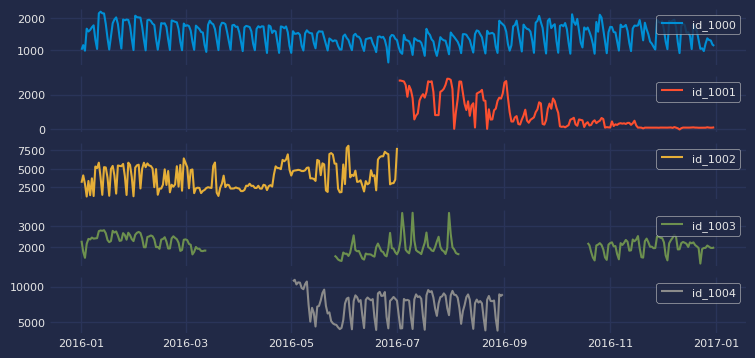

In [11]:
# Plot series
# ==============================================================================
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, axs = plt.subplots(5, 1, figsize=(8, 4), sharex=True)
for i, s in enumerate(series_dict.values()):
    axs[i].plot(s, label=s.name, color=colors[i])
    axs[i].legend(loc='upper right', fontsize=8)
    axs[i].tick_params(axis='both', labelsize=8)

In [12]:
# Description of each partition
# ==============================================================================
for k in series_dict.keys():
    print(f"{k}:")
    try:
        print(
            f"\tTrain: len={len(series_dict_train[k])}, {series_dict_train[k].index[0]}"
            f" --- {series_dict_train[k].index[-1]}"
        )
    except:
        print(f"\tTrain: len=0")
    try:
        print(
            f"\tVal  : len={len(series_dict_val[k])}, {series_dict_val[k].index[0]}"
            f" --- {series_dict_val[k].index[-1]}"
        )
    except:
        print(f"\tVal  : len=0")
    try:
        print(
            f"\tTest : len={len(series_dict_test[k])}, {series_dict_test[k].index[0]}"
            f" --- {series_dict_test[k].index[-1]}"
        )
    except:
        print(f"\tTest : len=0")

id_1000:
	Train: len=213, 2016-01-01 00:00:00 --- 2016-07-31 00:00:00
	Val  : len=61, 2016-08-01 00:00:00 --- 2016-09-30 00:00:00
	Test : len=92, 2016-10-01 00:00:00 --- 2016-12-31 00:00:00
id_1001:
	Train: len=30, 2016-07-02 00:00:00 --- 2016-07-31 00:00:00
	Val  : len=61, 2016-08-01 00:00:00 --- 2016-09-30 00:00:00
	Test : len=92, 2016-10-01 00:00:00 --- 2016-12-31 00:00:00
id_1002:
	Train: len=183, 2016-01-01 00:00:00 --- 2016-07-01 00:00:00
	Val  : len=0
	Test : len=0
id_1003:
	Train: len=213, 2016-01-01 00:00:00 --- 2016-07-31 00:00:00
	Val  : len=61, 2016-08-01 00:00:00 --- 2016-09-30 00:00:00
	Test : len=92, 2016-10-01 00:00:00 --- 2016-12-31 00:00:00
id_1004:
	Train: len=91, 2016-05-02 00:00:00 --- 2016-07-31 00:00:00
	Val  : len=31, 2016-08-01 00:00:00 --- 2016-08-31 00:00:00
	Test : len=0


In [13]:
# Exogenous variables for each series
# ==============================================================================
for k in series_dict.keys():
    print(f"{k}:")
    try:
        print(f"\t{exog_dict[k].columns.to_list()}")
    except:
        print(f"\tNo exogenous variables")

id_1000:
	['sin_day_of_week', 'cos_day_of_week']
id_1001:
	['sin_day_of_week', 'cos_day_of_week', 'air_temperature', 'wind_speed']
id_1002:
	['sin_day_of_week', 'cos_day_of_week', 'air_temperature', 'wind_speed']
id_1003:
	['sin_day_of_week', 'cos_day_of_week', 'air_temperature', 'wind_speed']
id_1004:
	['sin_day_of_week', 'cos_day_of_week', 'air_temperature', 'wind_speed']


## Series is dataframe (filled with NaNs) and exog is dictionary

In [15]:
# Series is dataframe and exog is dictionary
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                regressor=LGBMRegressor(n_estimators=10, random_state=123, verbose=-1),
                lags=14,
                encoding="ordinal",
                dropna_from_series=False,
                transformer_series=StandardScaler(),            
            )
forecaster.fit(series=series_df_train, exog=exog_dict_train, suppress_warnings=True)
predictions_1 = forecaster.predict(steps=5, exog=exog_dict_val)
predictions_1

c:\Users\Joaquín Amat\Documents\GitHub\skforecast\skforecast\utils\utils.py:850: MissingExogWarning: {'air_temperature', 'wind_speed'} not present in `exog` for series 'id_1000'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
c:\Users\Joaquín Amat\Documents\GitHub\skforecast\skforecast\utils\utils.py:411: MissingValuesWarning: `exog` for series 'id_1000' has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


,id_1000,id_1001,id_1003,id_1004
2016-08-01,1394.276927,2392.921258,2511.194645,7603.716810
2016-08-02,1418.811542,2426.353956,2219.315130,7743.505865
2016-08-03,1419.502612,2335.709398,2123.562515,8175.269140
2016-08-04,1409.022008,2292.691635,2106.626013,8272.953203
2016-08-05,1373.139663,2222.711585,2128.060600,8117.061254


## Series is dictionary and exog is dictionary

In [23]:
# Series is dictionary and exog is dictionary
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                regressor=LGBMRegressor(n_estimators=10, random_state=123, verbose=-1),
                lags=14,
                encoding="ordinal",
                dropna_from_series=False,
                transformer_series=StandardScaler(),            
            )
forecaster.fit(series=series_dict_train, exog=exog_dict_train)
predictions = forecaster.predict(steps=5, exog=exog_dict_val)
predictions

c:\Users\Joaquín Amat\Documents\GitHub\skforecast\skforecast\ForecasterAutoregMultiSeries\ForecasterAutoregMultiSeries.py:766: MissingValuesWarning: NaNs detected in `y_train`. They have been dropped because the target variable cannot have NaN values. Same rows have been dropped from `X_train` to maintain alignment. This is caused by series with interspersed NaNs. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
c:\Users\Joaquín Amat\Documents\GitHub\skforecast\skforecast\ForecasterAutoregMultiSeries\ForecasterAutoregMultiSeries.py:789: MissingValuesWarning: NaNs detected in `X_train`. Some regressors do not allow NaN values during training. If you want to drop them, set `forecaster.dropna_from_series = True`. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
c:\Users\Joaquín Amat\Documents\GitHub\skforecast\skforecast\utils\utils.py:850: MissingExo

,id_1000,id_1001,id_1003,id_1004
2016-08-01,1394.276927,2392.921258,2511.194645,7603.716810
2016-08-02,1418.811542,2426.353956,2219.315130,7743.505865
2016-08-03,1419.502612,2335.709398,2123.562515,8175.269140
2016-08-04,1409.022008,2292.691635,2106.626013,8272.953203
2016-08-05,1373.139663,2222.711585,2128.060600,8117.061254


In [18]:
pd.testing.assert_frame_equal(predictions_1, predictions_2)

## Backtesting

c:\Users\Joaquín Amat\Documents\GitHub\skforecast\skforecast\ForecasterAutoregMultiSeries\ForecasterAutoregMultiSeries.py:789: MissingValuesWarning: NaNs detected in `X_train`. Some regressors do not allow NaN values during training. If you want to drop them, set `forecaster.dropna_from_series = True`. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


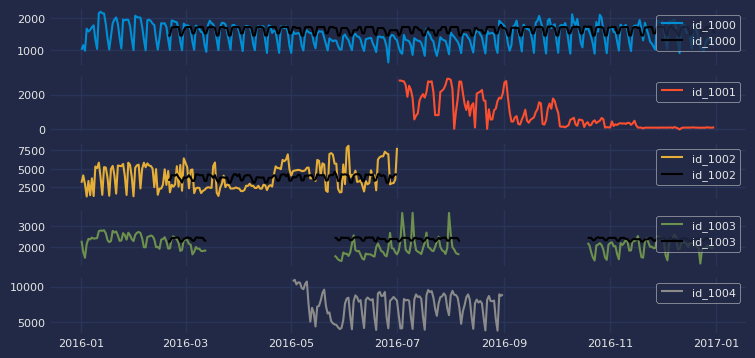

In [20]:
# Test backtesting
# ==============================================================================
params = {
    'refit' : False,
    'fixed_train_size': False,
    'gap': 0
}

forecaster = ForecasterAutoregMultiSeries(
    regressor=LGBMRegressor(n_estimators=10, random_state=123, verbose=-1),
    lags=14,
    encoding="ordinal",
    dropna_from_series=False,
    transformer_series=StandardScaler()
)

metrics_levels, backtest_predictions = backtesting_forecaster_multiseries(
    forecaster            = forecaster,
    series                = series_dict,
    exog                  = exog_dict,
    levels                = None,
    steps                 = 24,
    metric                = ['mean_absolute_error', 'mean_squared_error'],
    initial_train_size    = 50,
    fixed_train_size      = params['fixed_train_size'],
    gap                   = params['gap'],
    allow_incomplete_fold = True,
    refit                 = params['refit'],
    n_jobs                = 'auto',
    verbose               = False,
    show_progress         = False
)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, axs = plt.subplots(5, 1, figsize=(8, 4), sharex=True)
for i, s in enumerate(series_dict.keys()):
    axs[i].plot(series_dict[s], label=series_dict[s].name, color=colors[i])
    try:
        axs[i].plot(backtest_predictions[s], label=backtest_predictions[s].name, color="black")
    except:
        pass
    axs[i].legend(loc='upper right', fontsize=8)
    axs[i].tick_params(axis='both', labelsize=8)

## Bayesian Search

In [22]:
# Test Bayesian search
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                regressor=LGBMRegressor(n_estimators=10, random_state=123, verbose=-1),
                lags=14,
                encoding="ordinal",
                dropna_from_series=False,
                transformer_series=StandardScaler()
            )

lags_grid = [
    [5],
    [1, 7, 14]
]

def search_space(trial):
    search_space  = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 1.0, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 25, 50, step=100),
        "max_depth": trial.suggest_int('max_depth', 2, 5),
        "subsample": trial.suggest_float("subsample", 0.3, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.3, 1.0),
        'lags' : trial.suggest_categorical('lags', lags_grid)
    }

    return search_space

with warnings.catch_warnings():
    warnings.filterwarnings('ignore', category=UserWarning, module='optuna')

    results_search_1, best_trial_1 = bayesian_search_forecaster_multiseries(
        forecaster         = forecaster,
        series             = series_dict,
        exog               = exog_dict,
        search_space       = search_space,
        metric             = 'mean_absolute_error',
        initial_train_size = len(series_train),
        steps              = 10,
        refit              = False,
        n_trials           = 5,
        return_best        = False,
        show_progress      = False,
        verbose            = False
    )

results_search_1


Number of models compared: 5,
         5 bayesian search in each lag configuration.


c:\Users\Joaquín Amat\Documents\GitHub\skforecast\skforecast\ForecasterAutoregMultiSeries\ForecasterAutoregMultiSeries.py:766: MissingValuesWarning: NaNs detected in `y_train`. They have been dropped because the target variable cannot have NaN values. Same rows have been dropped from `X_train` to maintain alignment. This is caused by series with interspersed NaNs. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
c:\Users\Joaquín Amat\Documents\GitHub\skforecast\skforecast\ForecasterAutoregMultiSeries\ForecasterAutoregMultiSeries.py:789: MissingValuesWarning: NaNs detected in `X_train`. Some regressors do not allow NaN values during training. If you want to drop them, set `forecaster.dropna_from_series = True`. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
c:\Users\Joaquín Amat\Documents\GitHub\skforecast\skforecast\ForecasterAutoregMultiSeries\F

,levels,lags,params,mean_absolute_error,learning_rate,n_estimators,max_depth,subsample,colsample_bytree,lags
4,"[id_1000, id_1001, id_1002, id_1003, id_1004]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'learning_rate': 0.07758424358283758, 'n_esti...",527.801239,0.077584,25,3,0.553252,0.459784,"[1, 7, 14]"
0,"[id_1000, id_1001, id_1002, id_1003, id_1004]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'learning_rate': 0.06107686573608482, 'n_esti...",547.730261,0.061077,25,3,0.458796,0.685920,[5]
1,"[id_1000, id_1001, id_1002, id_1003, id_1004]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'learning_rate': 0.8376388146302433, 'n_estim...",561.434225,0.837639,25,4,0.636652,0.574482,"[1, 7, 14]"
3,"[id_1000, id_1001, id_1002, id_1003, id_1004]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'learning_rate': 0.013372281038573085, 'n_est...",741.762738,0.013372,25,4,0.744081,0.894602,[5]
2,"[id_1000, id_1001, id_1002, id_1003, id_1004]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'learning_rate': 0.005679223741740077, 'n_est...",805.681905,0.005679,25,2,0.578631,0.816597,[5]


## Series is dictionary with NaNs interspersed and exog is dictionary

In [24]:
series_dict['id_1002'].at['2016-02-01'] = np.nan
series_dict['id_1002'].at['2016-05-01'] = np.nan

In [25]:
# Series is dictionary and exog is dictionary
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                regressor=LGBMRegressor(n_estimators=10, random_state=123, verbose=-1),
                lags=14,
                encoding="ordinal",
                dropna_from_series=False,
                transformer_series=StandardScaler(),            
            )
forecaster.fit(series=series_dict_train, exog=exog_dict_train)
predictions = forecaster.predict(steps=5, exog=exog_dict_val)
predictions

c:\Users\Joaquín Amat\Documents\GitHub\skforecast\skforecast\ForecasterAutoregMultiSeries\ForecasterAutoregMultiSeries.py:766: MissingValuesWarning: NaNs detected in `y_train`. They have been dropped because the target variable cannot have NaN values. Same rows have been dropped from `X_train` to maintain alignment. This is caused by series with interspersed NaNs. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
c:\Users\Joaquín Amat\Documents\GitHub\skforecast\skforecast\ForecasterAutoregMultiSeries\ForecasterAutoregMultiSeries.py:789: MissingValuesWarning: NaNs detected in `X_train`. Some regressors do not allow NaN values during training. If you want to drop them, set `forecaster.dropna_from_series = True`. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
c:\Users\Joaquín Amat\Documents\GitHub\skforecast\skforecast\utils\utils.py:850: MissingExo

,id_1000,id_1001,id_1003,id_1004
2016-08-01,1346.526709,2358.795448,2458.275051,8076.922788
2016-08-02,1402.933366,2308.551229,2253.945800,8388.586786
2016-08-03,1426.861295,2196.482721,2160.584136,8141.853450
2016-08-04,1385.295338,2335.597540,2105.835058,8063.913923
2016-08-05,1349.322751,2188.527743,2085.382953,8128.082279


c:\Users\Joaquín Amat\Documents\GitHub\skforecast\skforecast\ForecasterAutoregMultiSeries\ForecasterAutoregMultiSeries.py:766: MissingValuesWarning: NaNs detected in `y_train`. They have been dropped because the target variable cannot have NaN values. Same rows have been dropped from `X_train` to maintain alignment. This is caused by series with interspersed NaNs. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
c:\Users\Joaquín Amat\Documents\GitHub\skforecast\skforecast\ForecasterAutoregMultiSeries\ForecasterAutoregMultiSeries.py:789: MissingValuesWarning: NaNs detected in `X_train`. Some regressors do not allow NaN values during training. If you want to drop them, set `forecaster.dropna_from_series = True`. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


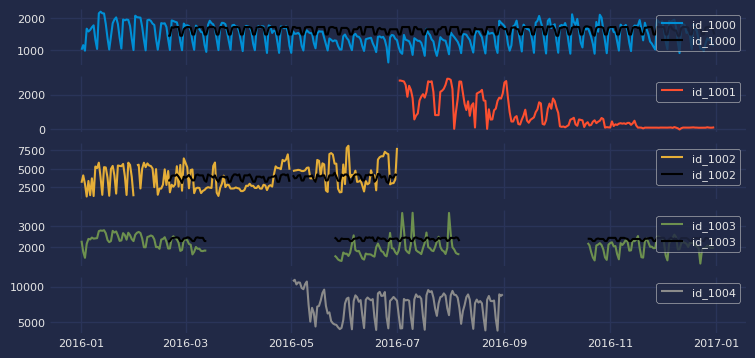

In [26]:
# Test backtesting
# ==============================================================================
params = {
    'refit' : False,
    'fixed_train_size': False,
    'gap': 0
}

forecaster = ForecasterAutoregMultiSeries(
    regressor=LGBMRegressor(n_estimators=10, random_state=123, verbose=-1),
    lags=14,
    encoding="ordinal",
    dropna_from_series=False,
    transformer_series=StandardScaler()
)

metrics_levels, backtest_predictions = backtesting_forecaster_multiseries(
    forecaster            = forecaster,
    series                = series_dict,
    exog                  = exog_dict,
    levels                = None,
    steps                 = 24,
    metric                = ['mean_absolute_error', 'mean_squared_error'],
    initial_train_size    = 50,
    fixed_train_size      = params['fixed_train_size'],
    gap                   = params['gap'],
    allow_incomplete_fold = True,
    refit                 = params['refit'],
    n_jobs                = 'auto',
    verbose               = False,
    show_progress         = False
)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, axs = plt.subplots(5, 1, figsize=(8, 4), sharex=True)
for i, s in enumerate(series_dict.keys()):
    axs[i].plot(series_dict[s], label=series_dict[s].name, color=colors[i])
    try:
        axs[i].plot(backtest_predictions[s], label=backtest_predictions[s].name, color="black")
    except:
        pass
    axs[i].legend(loc='upper right', fontsize=8)
    axs[i].tick_params(axis='both', labelsize=8)